In [1]:
%matplotlib inline

In [2]:
import itertools
import pickle
import gc
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import mne_bids
import librosa as lbr

In [3]:
ROOT = Path("../data/MASC-MEG")

EPOCHS_ID = "250Hz-800ms-sub12"

EPOCHS_ROOT = Path("../data/formatted/phonemes/")

sorted(EPOCHS_ROOT.rglob("*"))

[PosixPath('../data/formatted/phonemes/audio-12-phoneme-250Hz-800ms.test.npy'),
 PosixPath('../data/formatted/phonemes/audio-12-phoneme-250Hz-800ms.train.npy'),
 PosixPath('../data/formatted/phonemes/epochs-12-phoneme-250Hz-800ms.test.npy'),
 PosixPath('../data/formatted/phonemes/epochs-12-phoneme-250Hz-800ms.train.npy'),
 PosixPath('../data/formatted/phonemes/info-12-phoneme-250Hz-800ms.pkl'),
 PosixPath('../data/formatted/phonemes/meta-12-phoneme-250Hz-800ms.csv')]

In [4]:
train_audio_path = sorted(EPOCHS_ROOT.rglob("audio*train*"))[0]
test_audio_path = sorted(EPOCHS_ROOT.rglob("audio*test*"))[0]

train_epochs_path = sorted(EPOCHS_ROOT.rglob("epochs*train*"))[0]
test_epochs_path = sorted(EPOCHS_ROOT.rglob("epochs*test*"))[0]

info_path = sorted(EPOCHS_ROOT.rglob("info*"))[0]
meta_path = sorted(EPOCHS_ROOT.rglob("meta*"))[0]

In [5]:
phoneme_info = pd.read_csv(ROOT / "phoneme_info.csv")
phoneme_list = phoneme_info.phoneme.tolist()

In [6]:
from pathlib import Path
import yaml


def load_parameters(param_path):
    with open(param_path, "r") as fp:
        params = Parameters(**yaml.load(fp, yaml.Loader))
    return params


class Parameters(dict):
    def __getattr__(self, attr):
        try:
            if isinstance(self[attr], dict):
                return Parameters(**self[attr])
            return self[attr]
        except KeyError:
            raise AttributeError(attr)

    def __getitem__(self, item):
        if item in self:
            if isinstance(self.get(item), dict):
                return Parameters(**self.get(item))
            return self.get(item)
        else:
            raise KeyError(item)

    def __repr__(self):
        return "Parameters " + super(Parameters, self).__repr__()

    def __str__(self):
        return "Parameters " + super(Parameters, self).__str__()

    @property
    def sfreq(self):
        if "epochs" in self and "decim" in self.epochs:
            return self.sampling_rate / self.epochs.decim
        else:
            return self.sampling_rate

    def save(self, path):
        with open(path, "w+") as fp:
            yaml.dump(dict(**self), fp)

In [7]:
P = load_parameters(Path("../config/sound2meg-phoneme.yaml"))
pd.DataFrame(P)

meg       epochs  \
sfreq                                           1000          250   
bandpass                  {'high': 30.0, 'low': 0.5}          NaN   
sklearn_scaler                          RobustScaler          NaN   
scaler_params       {'quantile_range': [25.0, 75.0]}          NaN   
clip                                       [-20, 20]          NaN   
decim                                            NaN            4   
tmin                                             NaN         -0.2   
tmax                                             NaN          0.6   
baseline                                         NaN  [-0.2, 0.0]   
epoch_length                                     NaN          201   
mel_spec                                         NaN          NaN   
units                                            NaN          NaN   
lr                                               NaN          NaN   
sr                                               NaN          NaN   
input_scaling                                    NaN          NaN   
fb_scaling                                       NaN          NaN   
W                                                NaN          NaN   
rc_connectivity                                  NaN          NaN   
input_connectivity                               NaN          NaN   
input_bias                                       NaN          NaN   
ridge                                            NaN          NaN   

                                                                sound  \
sfreq                                                           22050   
bandpass                                                          NaN   
sklearn_scaler                                                    NaN   
scaler_params                                                     NaN   
clip                                                              NaN   
decim                                                             NaN   
tmin                                                              NaN   
tmax                                                              NaN   
baseline                                                          NaN   
epoch_length                                                      NaN   
mel_spec            {'hop_length': 128, 'n_fft': 2048, 'n_mels': 2...   
units                                                             NaN   
lr                                                                NaN   
sr                                                                NaN   
input_scaling                                                     NaN   
fb_scaling                                                        NaN   
W                                                                 NaN   
rc_connectivity                                                   NaN   
input_connectivity                                                NaN   
input_bias                                                        NaN   
ridge                                                             NaN   

                                                            reservoir  \
sfreq                                                             NaN   
bandpass                                                          NaN   
sklearn_scaler                                                    NaN   
scaler_params                                                     NaN   
clip                                                              NaN   
decim                                                             NaN   
tmin                                                              NaN   
tmax                                                              NaN   
baseline                                                          NaN   
epoch_length                                                      NaN   
mel_spec                                                          NaN   
units                                          

In [8]:
meta = pd.read_csv(meta_path)

In [9]:
with open(info_path, "rb+") as fp:
    info = pickle.load(fp)

In [10]:
X_train = np.load(train_audio_path)

In [11]:
y_train = np.load(train_epochs_path)

In [12]:
X_train.shape, y_train.shape

((30761, 201, 208), (30761, 208, 201))

In [13]:
N, T, n_mels = X_train.shape

In [14]:
y_train = y_train.reshape(N, T, -1)

In [15]:
_, _, n_chns = y_train.shape

In [44]:
from pprint import pprint

P_res = P.reservoir
P_read = P.readout

pprint(P_res)
pprint(P_read)

{'W': {'dist': 'uniform', 'params': {'high': 1.0, 'low': -1.0}},
 'fb_scaling': '0.001,',
 'input_bias': True,
 'input_connectivity': 0.2,
 'input_scaling': 1.0,
 'lr': 0.5,
 'rc_connectivity': 0.2,
 'sr': 0.99,
 'units': 500}
Parameters {'ridge': 1e-05, 'input_bias': False}


In [122]:
P_read.ridge = 1e-6
P_res.input_scaling = 0.05
P_res.W.params = dict(low=-0.5, high=0.5)
P_res.input_connectivity=0.1
P_res.rc_connectivity=0.1
P_res.lr = 1.0
P_res.sr = 1.2

In [123]:
from reservoirpy import mat_gen
from reservoirpy.nodes import Reservoir, Ridge, ESN
import reservoirpy as rpy
from reservoirpy import mat_gen

#W = getattr(mat_gen, P_res.W.dist)(**P_res.W.params)

rpy.verbosity(0)
rpy.set_seed(P.seed)

reservoir = Reservoir(
    P_res.units, 
    lr=P_res.lr, 
    sr=P_res.sr,
    input_scaling=P_res.input_scaling,
    input_bias=P_res.input_bias,
    #W=W,
    rc_connectivity=P_res.rc_connectivity,
    input_connectivity=P_res.input_connectivity
)

readout = Ridge(ridge=P_read.ridge, input_bias=False)

esn = ESN(reservoir=reservoir, readout=readout, workers=-1)

In [124]:
states = reservoir.run(X_train[10])

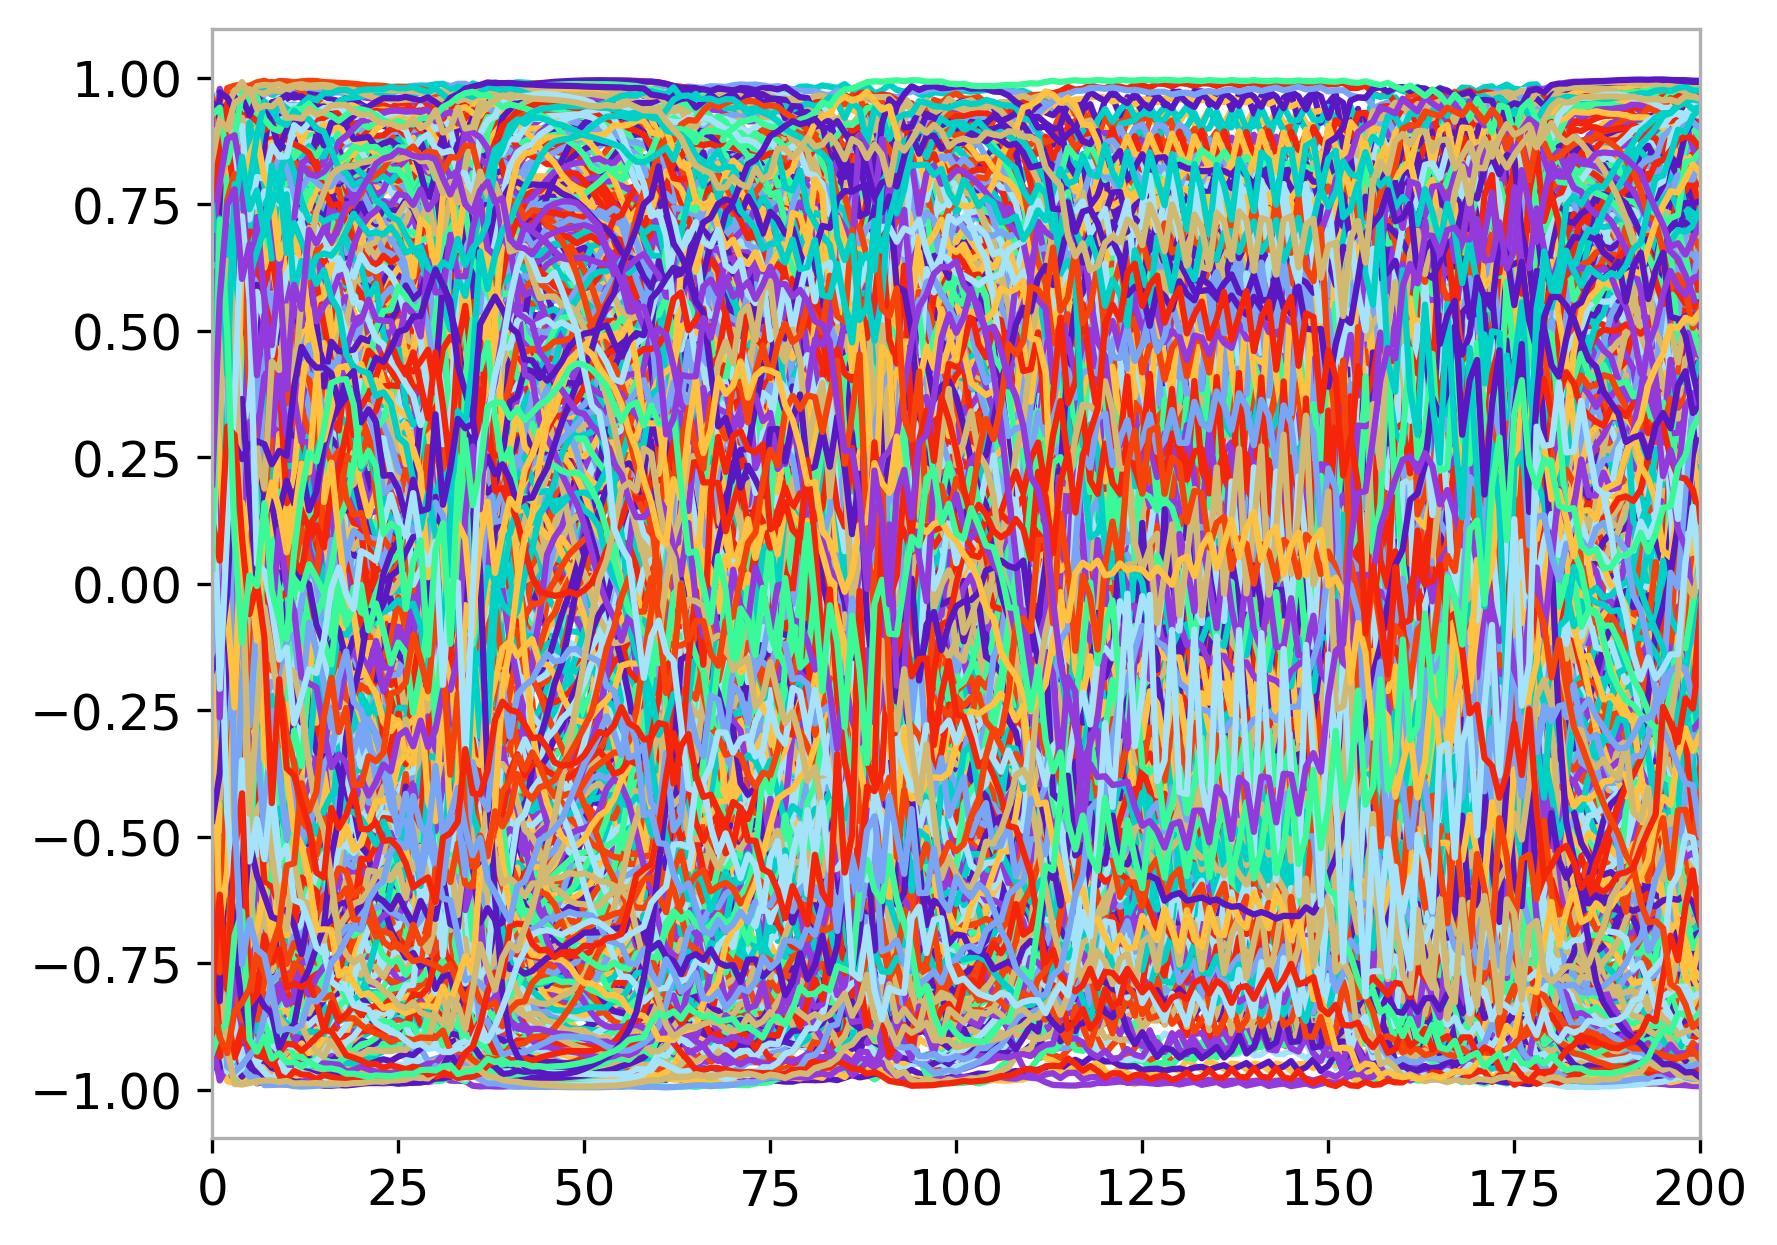

In [125]:
plt.plot(states)
plt.show()

In [126]:
warmup = round((P.epochs.baseline[1] - P.epochs.baseline[0]) * P.epochs.sfreq)
print(warmup)

50


In [127]:
esn = esn.fit(X_train, y_train, warmup=warmup)

In [128]:
X_test = np.load(test_audio_path)
y_test = np.load(test_epochs_path)

In [129]:
y_pred = esn.run(X_test)

In [130]:
pred_epochs = mne.EpochsArray(np.r_[y_pred].reshape(-1, n_chns, T), info)

Not setting metadata
2462 matching events found
No baseline correction applied
0 projection items activated


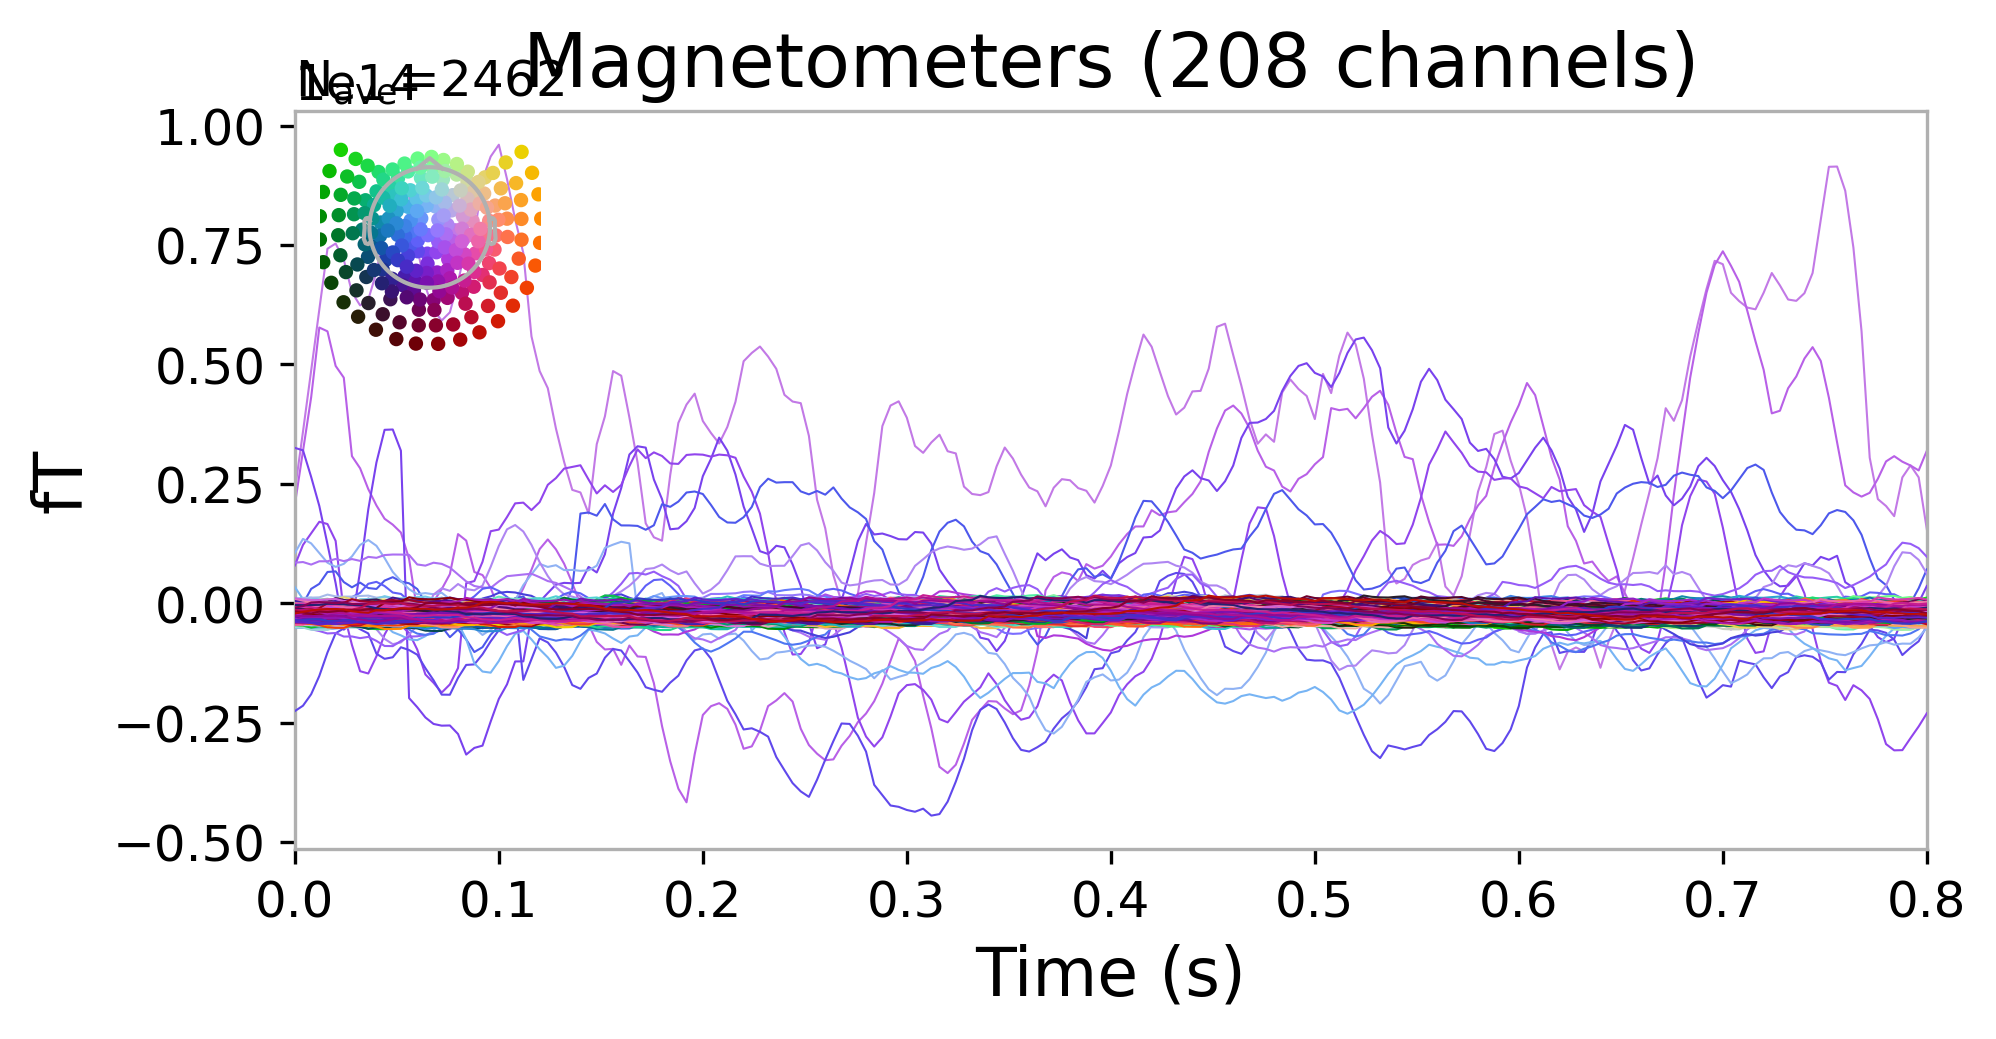

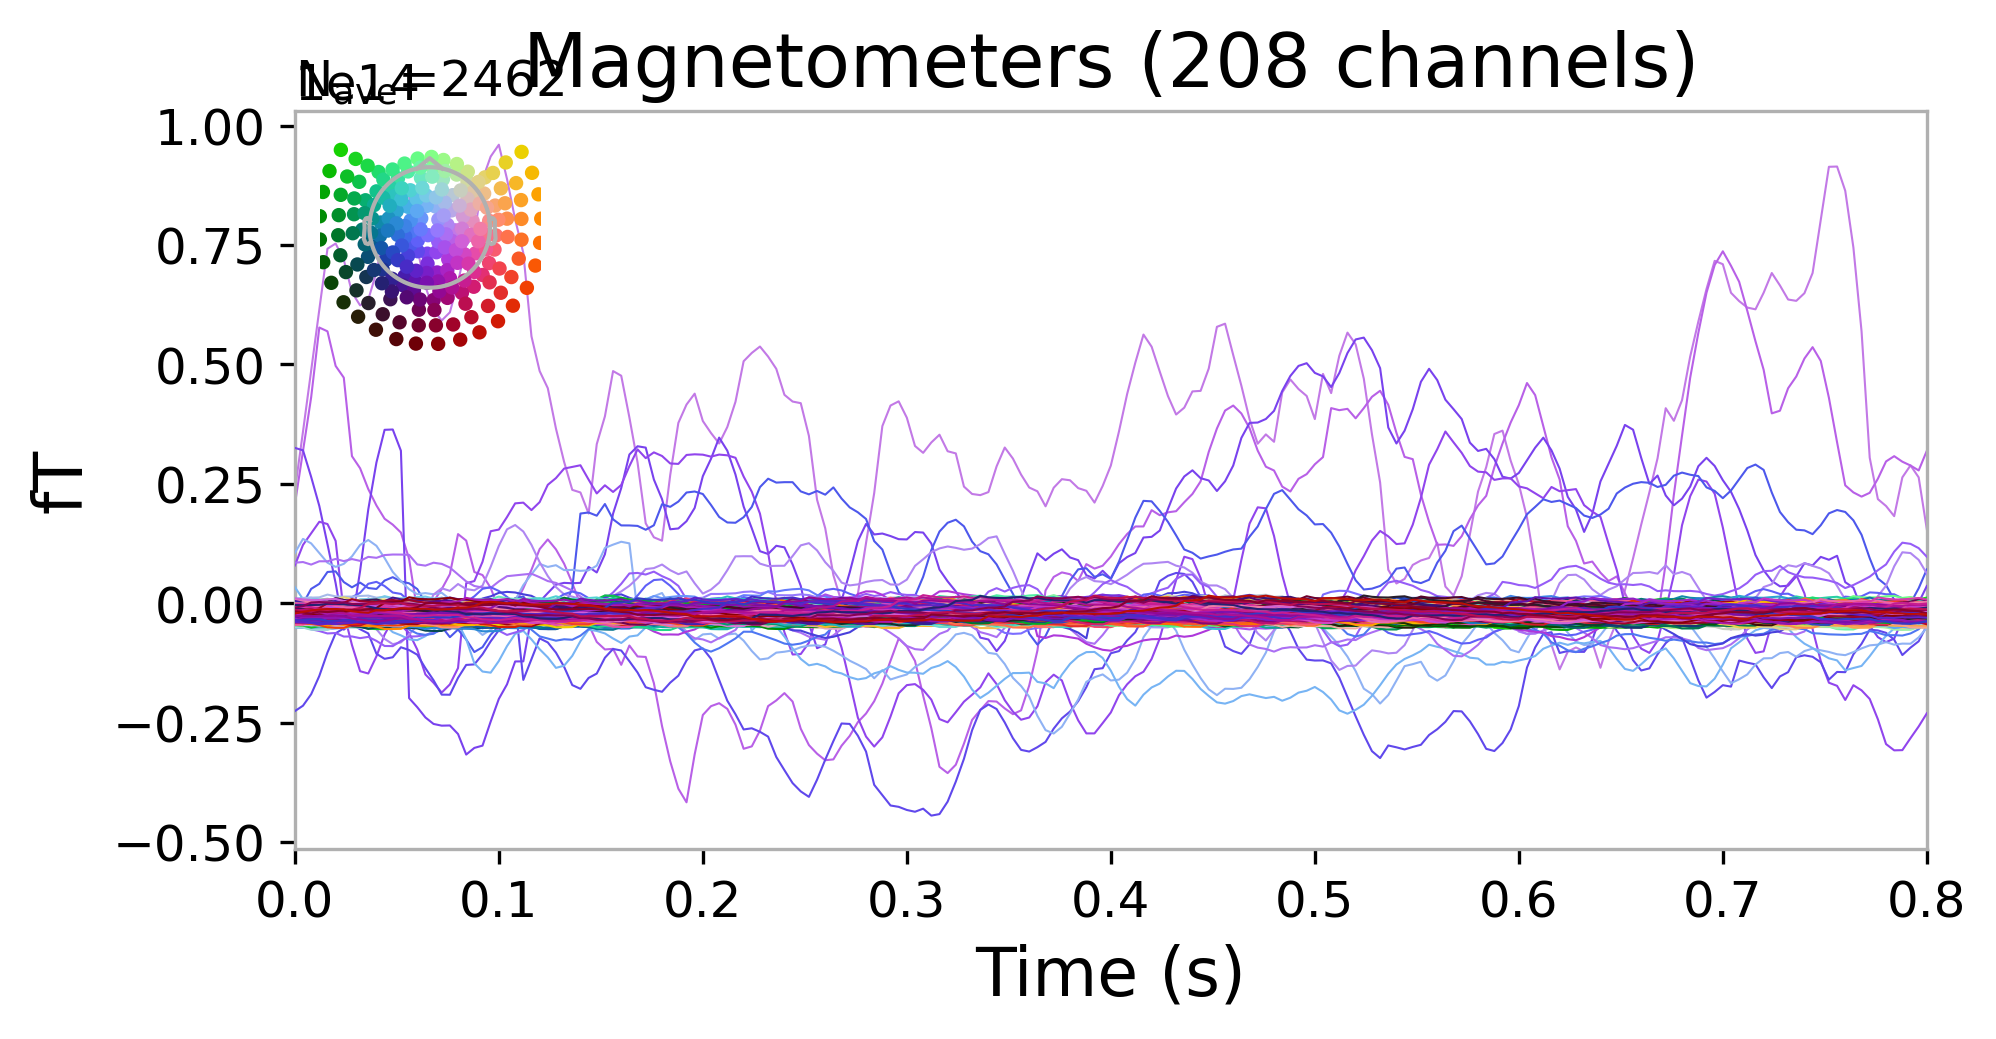

In [131]:
pred_epochs.average().plot()

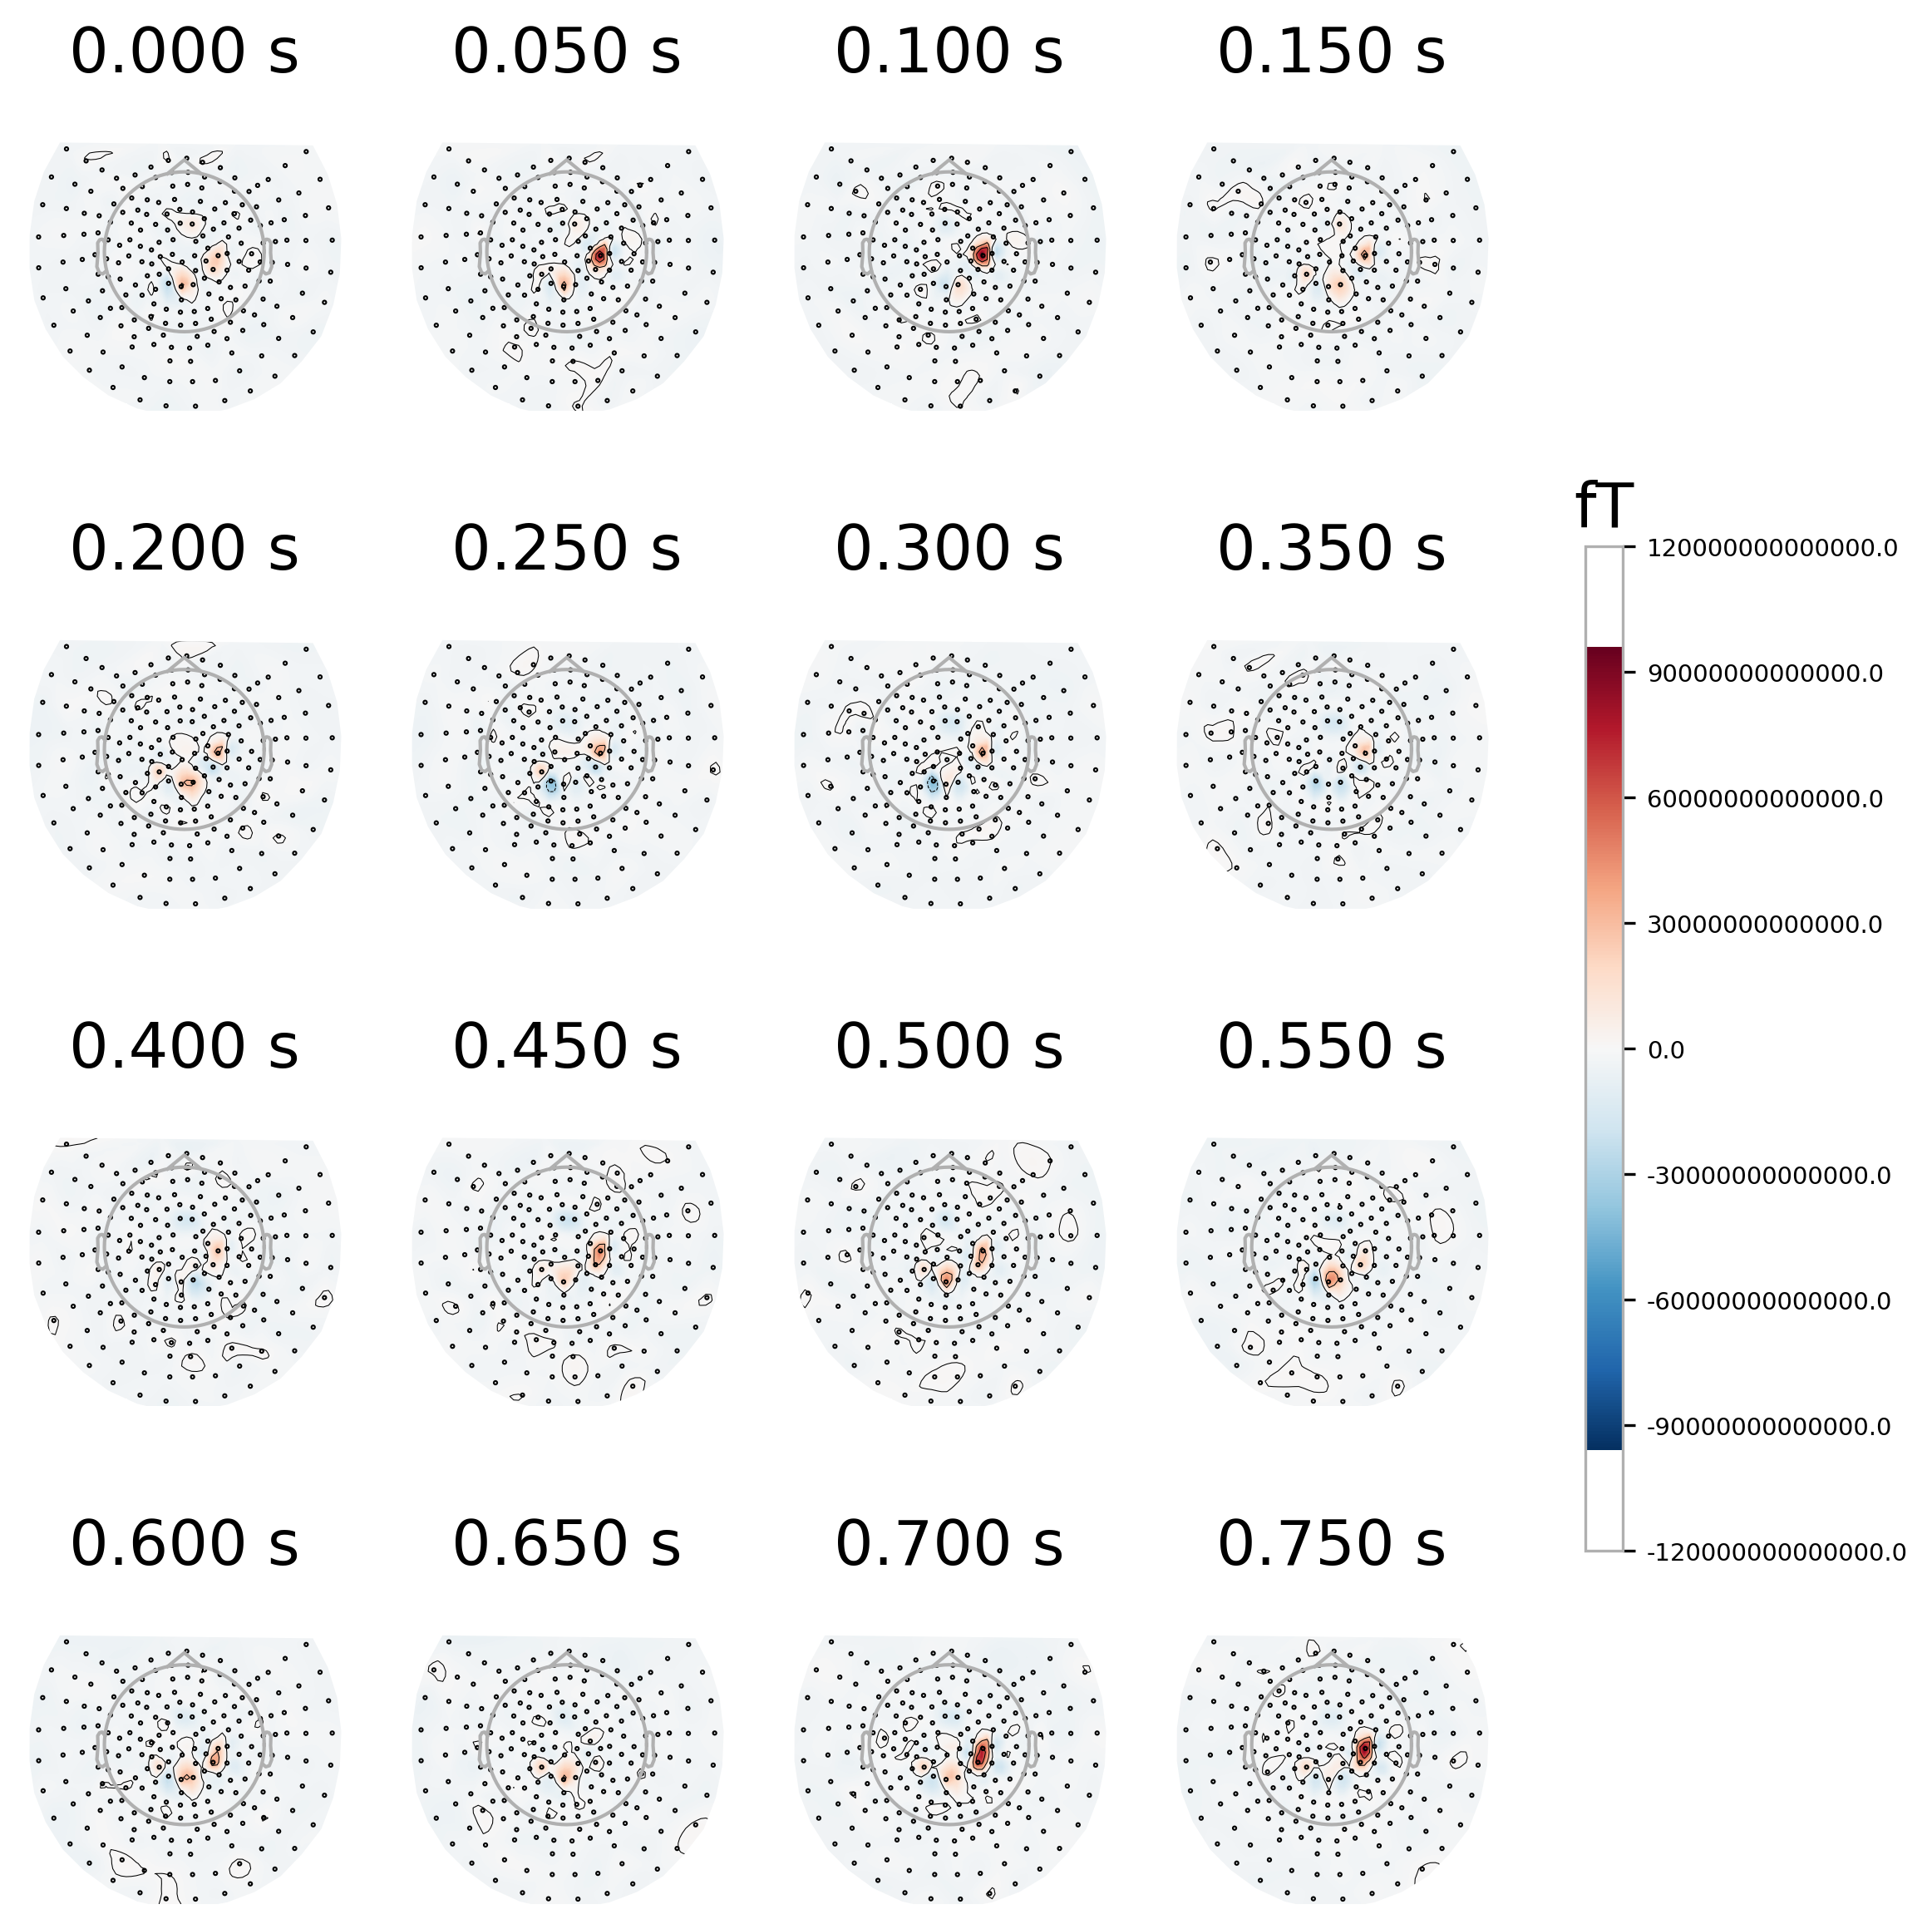

In [132]:
times = np.arange(0.00, 0.8, 0.05)
pred_epochs.average().plot_topomap(times=times, nrows = 4, ncols=4)
plt.show()

In [103]:
true_epochs = mne.EpochsArray(y_test.reshape(-1, n_chns, T), info)

Not setting metadata
2462 matching events found
No baseline correction applied
0 projection items activated


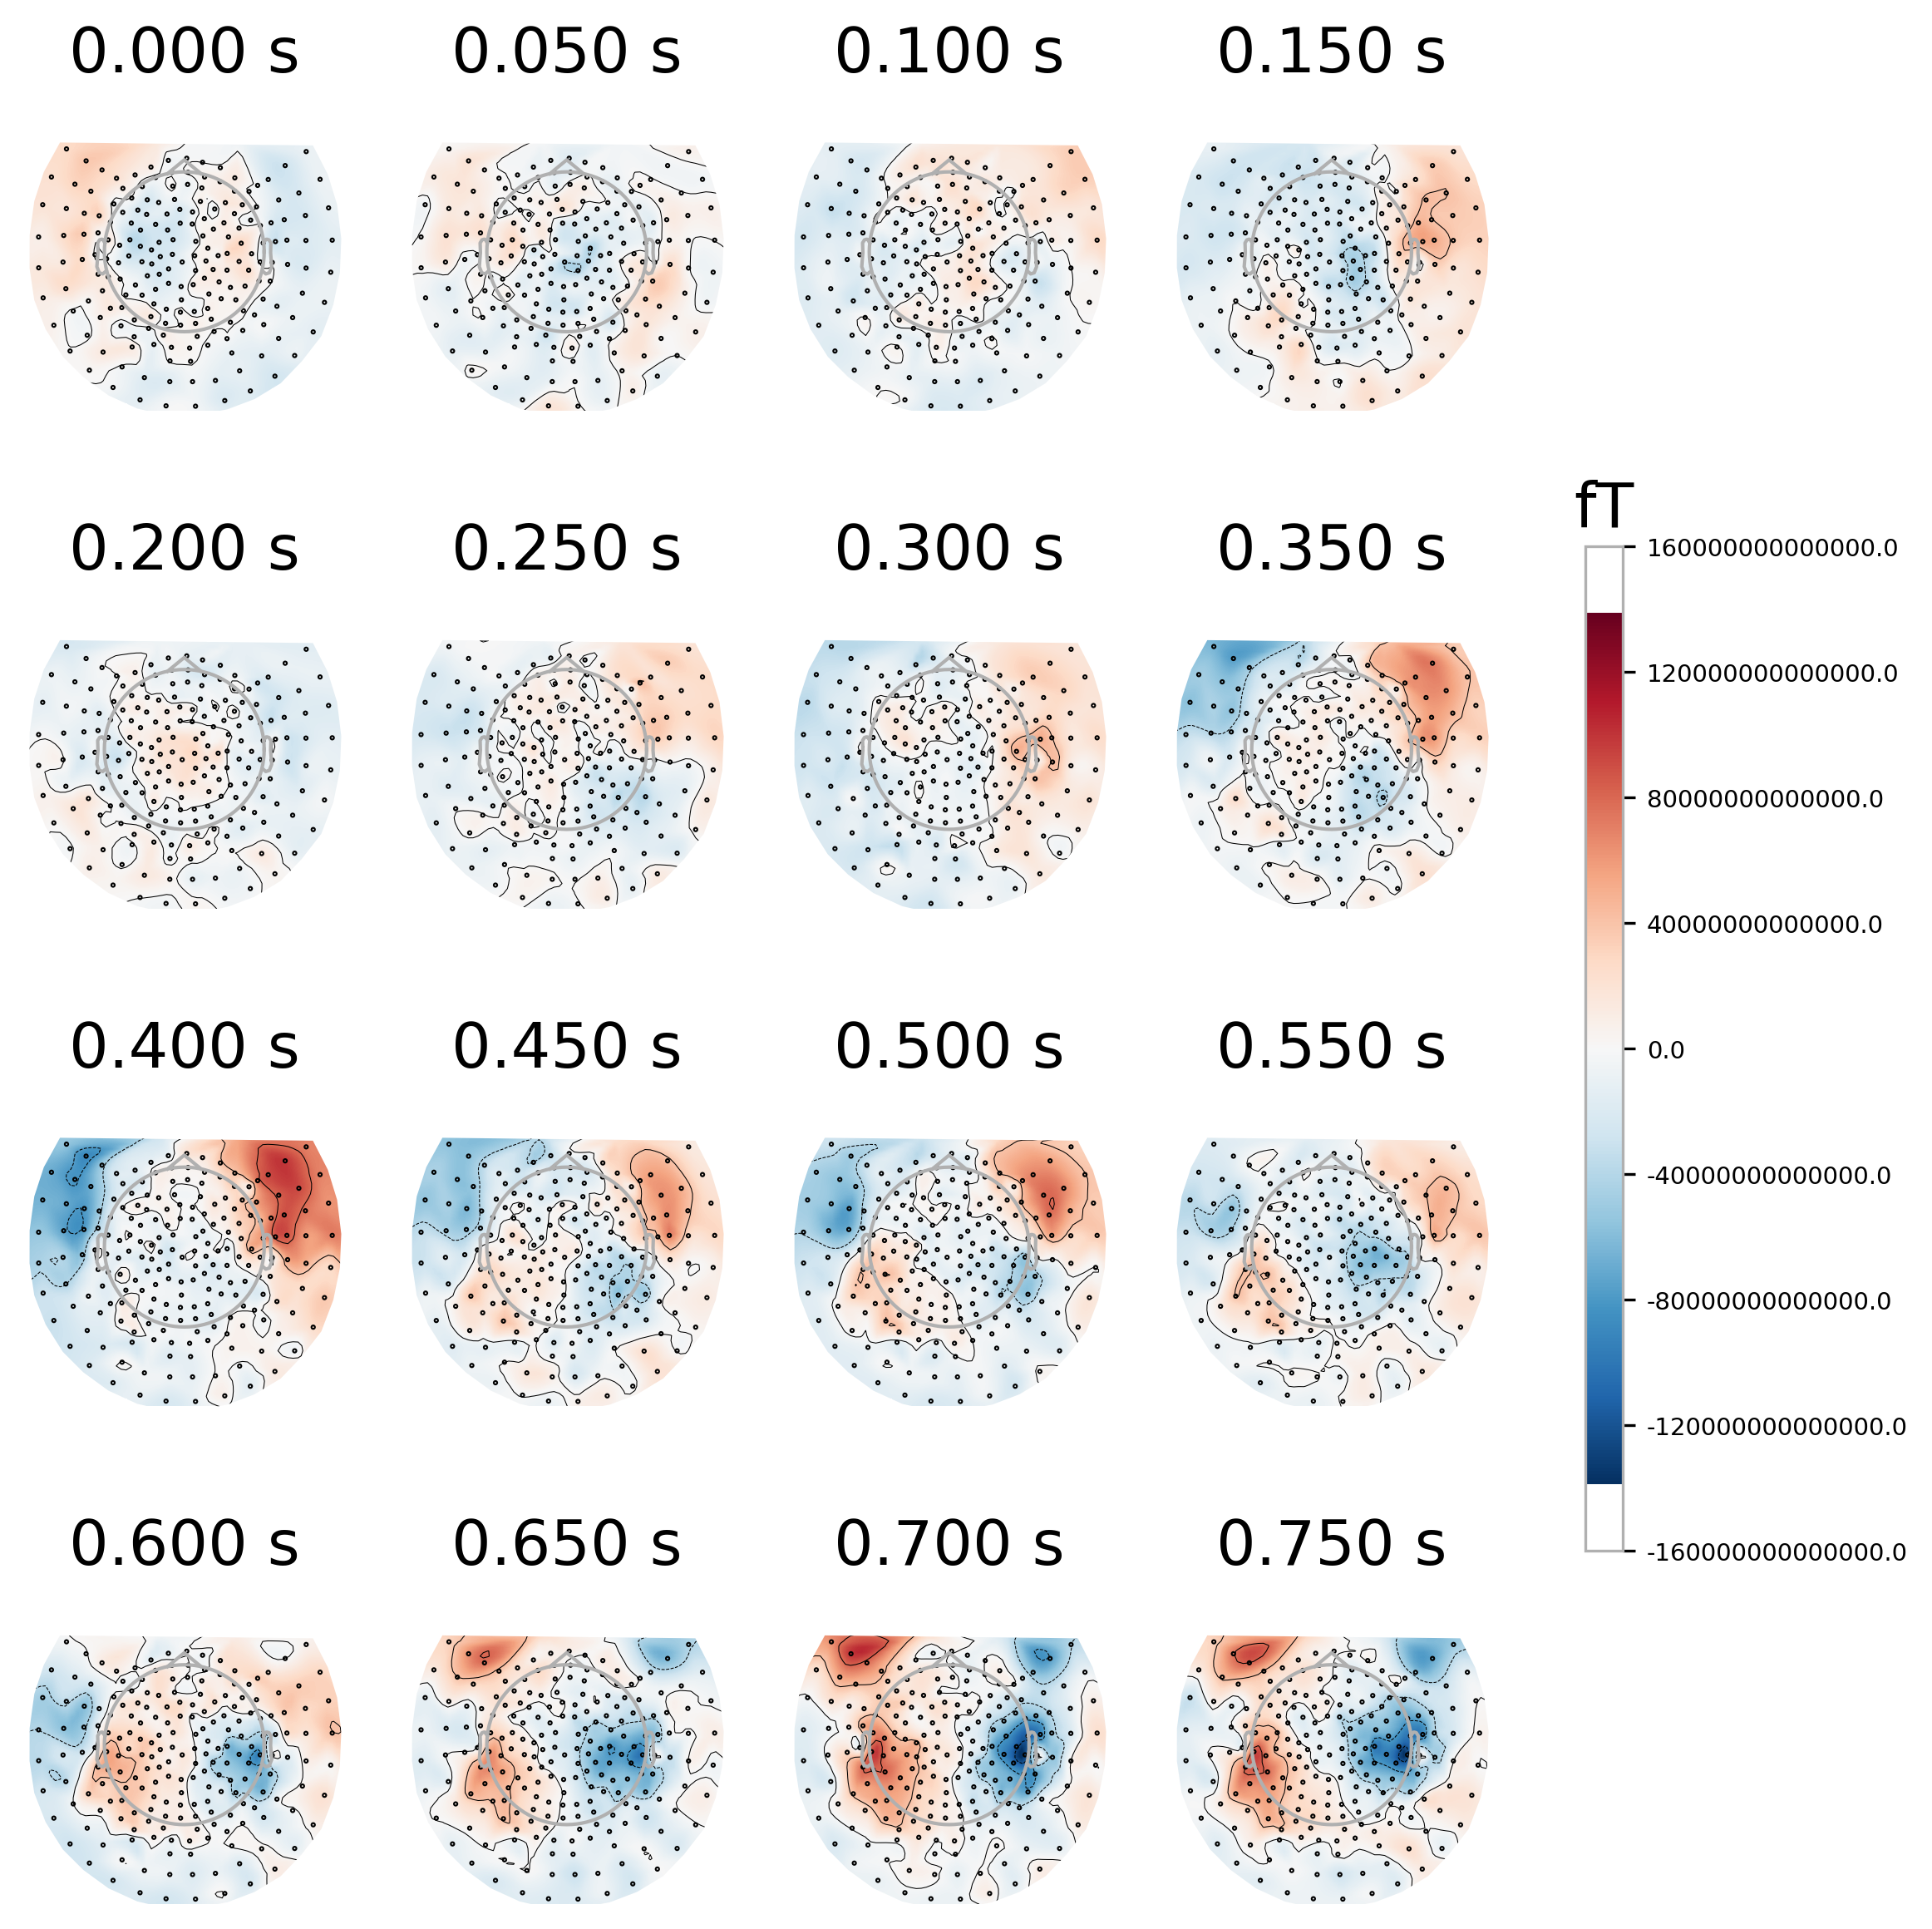

In [104]:
times = np.arange(0.00, 0.8, 0.05)
true_epochs.average().plot_topomap(times=times, nrows = 4, ncols=4)
plt.show()

In [30]:
from scipy.stats import zscore


def corr(X,Y):
    return np.mean(zscore(X)*zscore(Y),0)

def R2(Pred,Real):
    SSres = np.mean((Real-Pred)**2,0)
    SStot = np.var(Real,0)
    return np.nan_to_num(1-SSres/SStot)

def R2r(Pred,Real):
    R2rs = R2(Pred,Real)
    ind_neg = R2rs<0
    R2rs = np.abs(R2rs)
    R2rs = np.sqrt(R2rs)
    R2rs[ind_neg] *= - 1
    return R2rs

In [31]:
pearson_c = corr(np.r_[y_pred].reshape(-1, n_chns), y_test.reshape(-1, n_chns))
r2_c = R2(np.r_[y_pred].reshape(-1, n_chns), y_test.reshape(-1, n_chns))

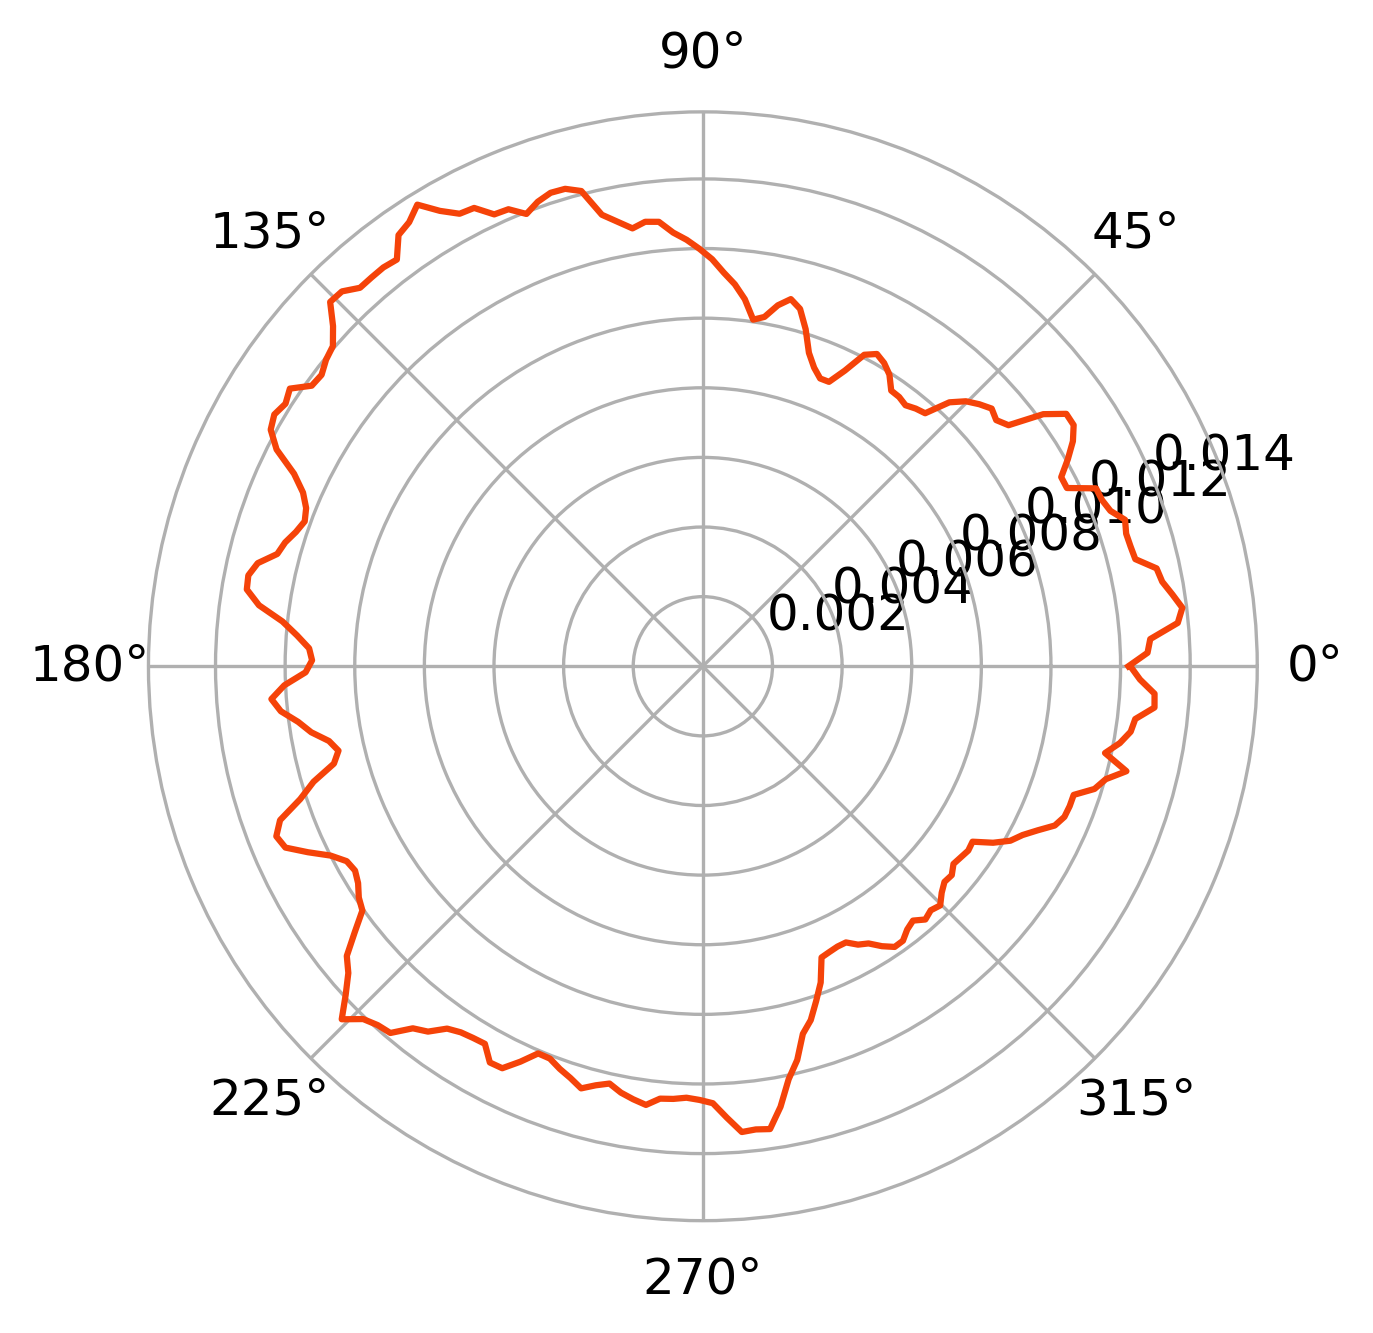

In [32]:
theta = np.linspace(0, 2*np.pi, n_chns)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, pearson_c)
ax.grid(True)
plt.show()

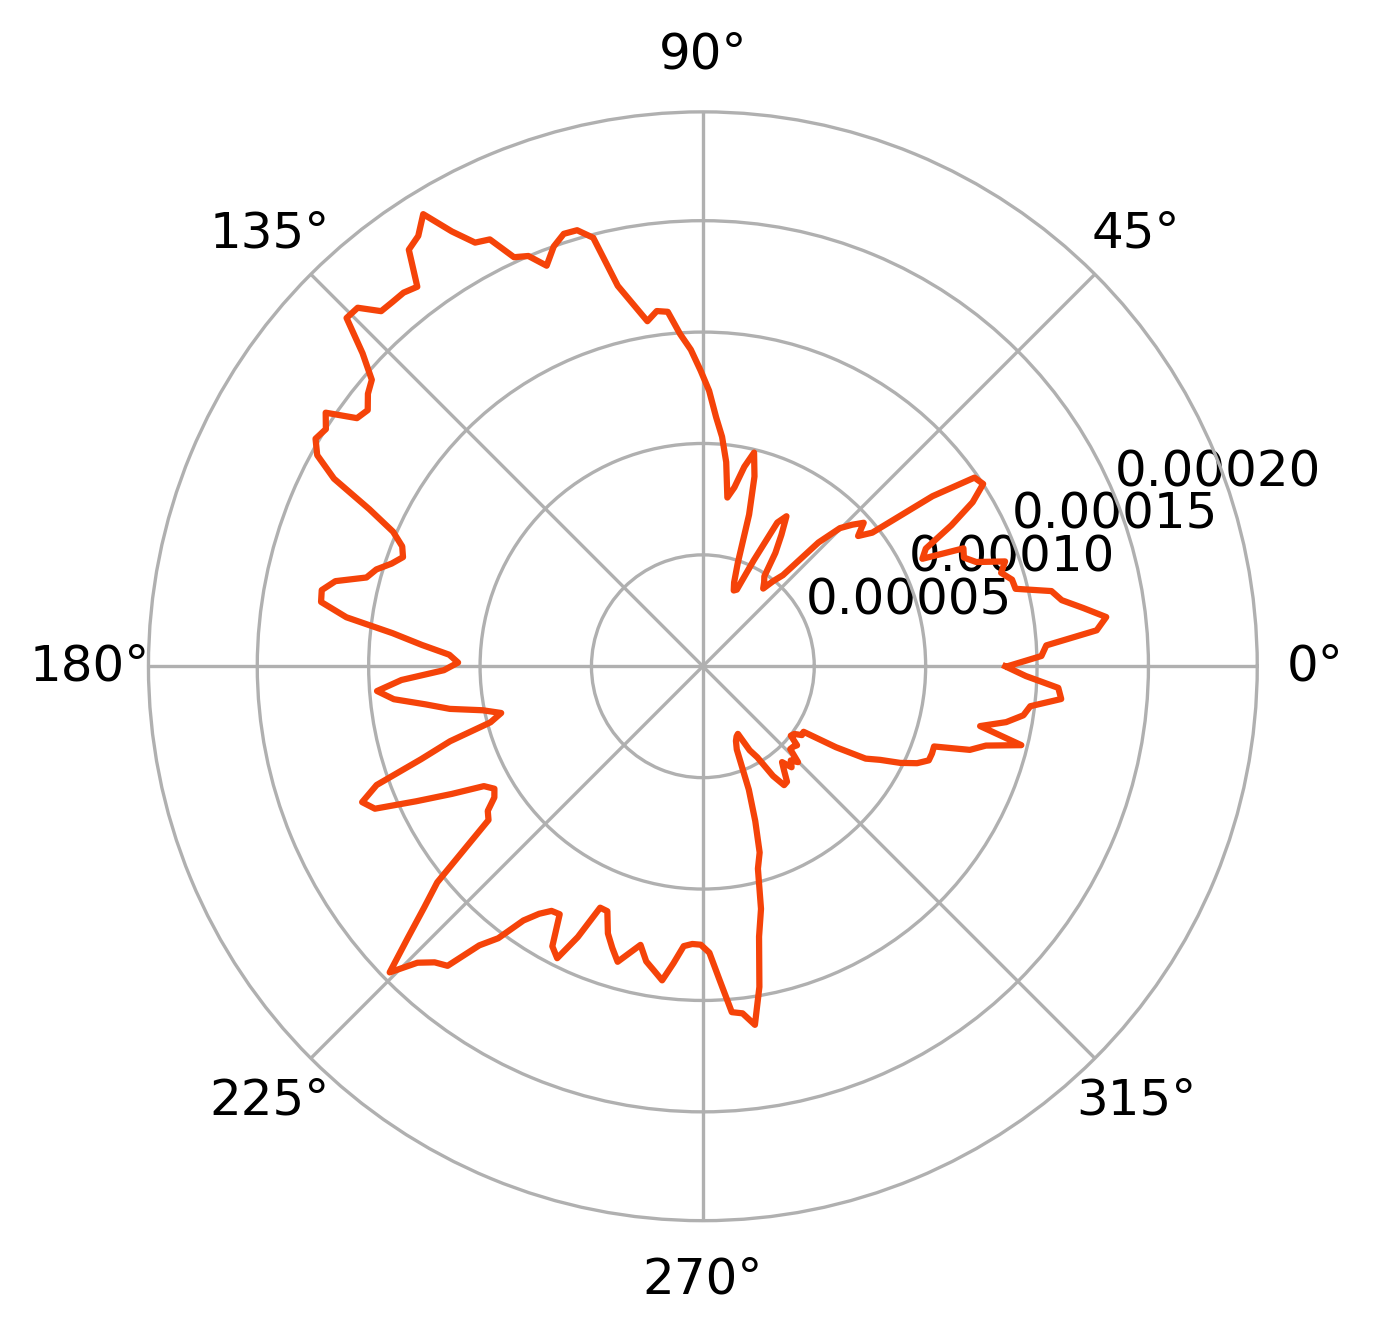

In [33]:
theta = np.linspace(0, 2*np.pi, n_chns)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, r2_c)
ax.grid(True)
plt.show()

In [134]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1e-6)

In [ ]:
ridge = ridge.fit(X_train.reshape(-1, n_mels), y_train.reshape(-1, n_chns))